# EDA: Fashion Trend Analysis
### Natalie Hammel, Ananya Shah, Jumana Alnahdi
#### MKTG4604

Our project consists of three main aspects 1) image classification of clothing types and styles, 2) trend analysis for popular clothing styles, cuts, and colors and 3) recommending clothing using content based filtering and collaborative filtering. 

For this exploratory analysis, we will be investigating the first tenent of our project. We will later train our model on these datasets. 

# 0. Importing Data + Loading Packages

In [2]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/f9/14/67e9b2b2379cb530c0412123a674d045eca387dfcfa7db1c0028857b0a66/tensorflow-2.16.1-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2dbd0ad4182ef2d53488bb02e58694cd79d61369e85900/flatbuffers-24.3.25-py2.py3-none-any.whl.metadata
  Obtaining dependency information for gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 from https://files.pythonhosted.org/packages/fa/39/5aae571

In [11]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

plt.rcParams['font.size'] = 16

In [14]:
pip install opendatasets

  Obtaining dependency information for opendatasets from https://files.pythonhosted.org/packages/00/e7/12300c2f886b846375c78a4f32c0ae1cd20bdcf305b5ac45b8d7eceda3ec/opendatasets-0.1.22-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [15]:
import opendatasets as od

In [16]:
od.download("https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nnnmmmhhh
Your Kaggle Key: ········
Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset


100%|██████████████████████████████████████| 23.1G/23.1G [08:34<00:00, 48.2MB/s]


In [17]:
img_path = '/Users/nataliehammel/Downloads/fashion-dataset/images'
img_df = pd.read_csv('fashion-product-images-dataset/fashion-dataset/images.csv')
styles_df = pd.read_csv('fashion-product-images-dataset/fashion-dataset/styles.csv', on_bad_lines='skip')

In [18]:
img_df.head()

filename                                               link
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...

In [19]:
styles_df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [20]:
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'

In [21]:
styles_df

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44419  17036    Men       Footwear       Shoes           Casual Shoes   
44420   6461    Men       Footwear  Flip Flops             Flip Flops   
44421  18842    Men        Apparel     Topwear                Tshirts   
44422  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44423  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44419      White  Summer  2013.0  Casual   
44420        Red  Summer  2011.0  Casual   
44421       Blue    Fall  2011.0  Casual   
44422       Blue  Spring  2017.0  Casual   
44423       Pink  Winter  2016.0  Casual   

                                    productDisplayName   filename  
0                     Turtle Check Men Navy Blue Shirt  15970.jpg  
1                   Peter England Men Party Blue Jeans  39386.jpg  
2                             Titan Women Silver Watch  59263.jpg  
3        Manchester United Men Solid Black Track Pants  21379.jpg  
4                                Puma Men Grey T-shirt  53759.jpg  
...                                                ...        ...  
44419                        Gas Men Caddy Casual Shoe  17036.jpg  
44420               Lotto Men's Soccer Track Flip Flop   6461.jpg  
44421             Puma Men Graphic Stellar Blue Tshirt  18842.jpg  
44422                   Rasasi Women Blue Lady Perfume  46694.jpg  
44423  Fossil Women Pink Dial Chronograph Watch ES3050  51623.jpg  

[44424 rows x 11 columns]

In [27]:
def list_dataset_files(dataset_path):
    file_paths = []
    for dirname, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            file_paths.append(os.path.join(dirname, filename))
    return file_paths

dataset_path = '/Users/nataliehammel/Downloads/fashion-dataset/images'
files = list_dataset_files(dataset_path)
print(files)

['/Users/nataliehammel/Downloads/fashion-dataset/images/9733.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/14147.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/52112.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/6400.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/34297.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/24084.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/12536.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/54563.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/15259.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/35189.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/44770.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/4217.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/47279.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/36480.jpg', '/Users/nataliehammel/Downloads/fashion-dataset/images/16750.jpg

In [29]:
img_files = os.listdir(img_path)

In [30]:
styles_df['present'] = styles_df['filename'].apply(lambda x:x in img_files)

In [31]:
styles_df = styles_df[styles_df['present']].reset_index(drop=True)

# 1. Some EDA

In [45]:
styles_df.head(5)

id gender masterCategory subCategory articleType baseColour  season  \
0  47670  Women    Accessories     Scarves     Scarves      Cream  Summer   
1  31980    Men       Footwear      Sandal     Sandals        Red  Summer   
2  26237    Men        Apparel     Topwear     Tshirts     Orange  Summer   
3   4260    Men        Apparel     Topwear     Tshirts     Yellow  Summer   
4  28023    Men        Apparel   Innerwear      Briefs        Red  Summer   

     year   usage                           productDisplayName   filename  \
0  2012.0  Casual  Femella Women Cream and Black Printed Scarf  47670.jpg   
1  2012.0  Casual            Nike Men Lebron Slide Red Sandals  31980.jpg   
2  2012.0  Casual           Proline Men Orange Printed T-shirt  26237.jpg   
3  2011.0  Casual    Inkfruit Men's Music Fever Yellow T-shirt   4260.jpg   
4  2016.0  Casual  Jockey ELANCE Men Red Pack of 2 Briefs 1004  28023.jpg   

   present  
0     True  
1     True  
2     True  
3     True  
4     True

In [223]:
styles_df['masterCategory'].value_counts()

masterCategory
Apparel           4787
Accessories       2588
Footwear          2076
Personal Care      520
Free Items          24
Sporting Goods       5
Name: count, dtype: int64

In [224]:
styles_df['subCategory'].value_counts()

subCategory
Topwear                     3468
Shoes                       1659
Bags                         687
Watches                      596
Bottomwear                   589
Innerwear                    396
Eyewear                      246
Fragrance                    229
Jewellery                    225
Sandal                       222
Wallets                      210
Belts                        198
Flip Flops                   195
Socks                        166
Dress                        110
Lips                         106
Loungewear and Nightwear     106
Saree                         90
Nails                         70
Makeup                        69
Ties                          64
Headwear                      59
Accessories                   32
Scarves                       32
Apparel Set                   26
Cufflinks                     25
Free Gifts                    24
Stoles                        20
Skin Care                     18
Skin                          1

In [111]:
styles_df.isna().sum()

id                     0
gender                 0
masterCategory         0
subCategory            0
articleType            0
baseColour             3
season                 2
year                   1
usage                 65
productDisplayName     1
filename               0
present                0
dtype: int64

In [51]:
def unique_value_counts_by_type(df, column):

    value_counts = {}
    for value in df[column].dropna().unique():
        dtype = type(value).__name__
        if dtype not in value_counts:
            value_counts[dtype] = {}
        value_counts[dtype][value] = df[column].value_counts().get(value, 0)
    return value_counts
 
value_counts = (unique_value_counts_by_type(styles_df, 'articleType'))

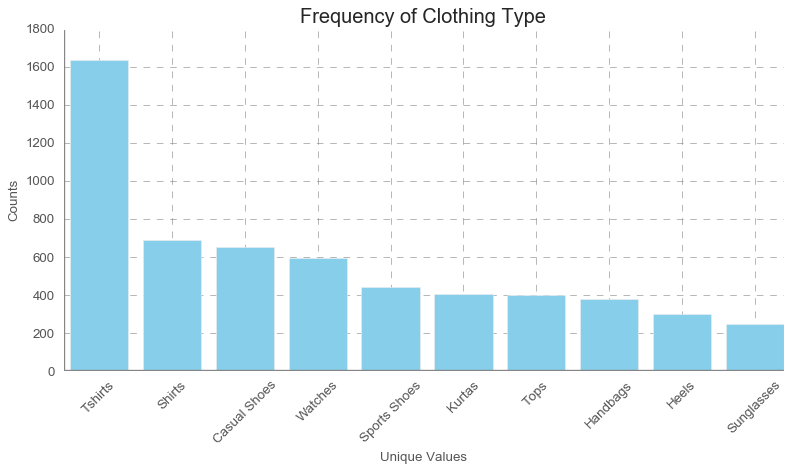

In [102]:
top_n = 10

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

for dtype, counts in value_counts.items():
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)[:top_n])
    plt.bar(sorted_counts.keys(), sorted_counts.values(), label=dtype, color = 'skyblue')

plt.axhline(y=0.5, color='gray', linewidth=3)  # Add horizontal line at y=0 (x-axis)
plt.axvline(x=-0.5, color='gray', linewidth=3)
plt.xlabel('Unique Values')
plt.gca().set_facecolor('white')  
plt.gcf().set_facecolor('white') 
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Counts')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Frequency of Clothing Type', fontsize = 18)
plt.tight_layout()
plt.show()

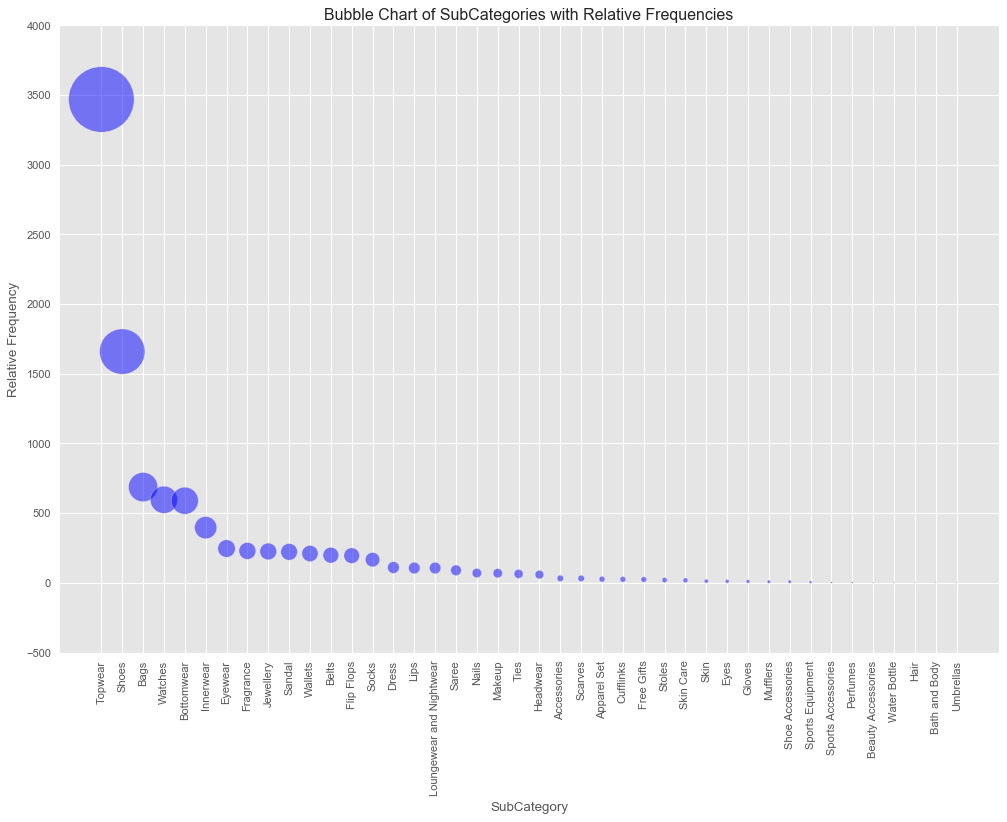

In [110]:
#Get the value counts of unique values in the 'subCategory' column
sub_category_counts_new = styles_df['subCategory'].value_counts()

# Get the unique subCategories and their counts
sub_categories_new = sub_category_counts_new.index
counts_new = sub_category_counts_new.values

# Plot the bubble chart with relative frequencies on the y-axis
plt.figure(figsize=(12, 8))
plt.scatter(sub_categories_new, counts_new, s=counts_new, alpha=0.5)
plt.xlabel('SubCategory')
plt.ylabel('Relative Frequency')
plt.title('Bubble Chart of SubCategories with Relative Frequencies')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.grid(True)  # Add a grid for better visibility of the bubbles
plt.show()

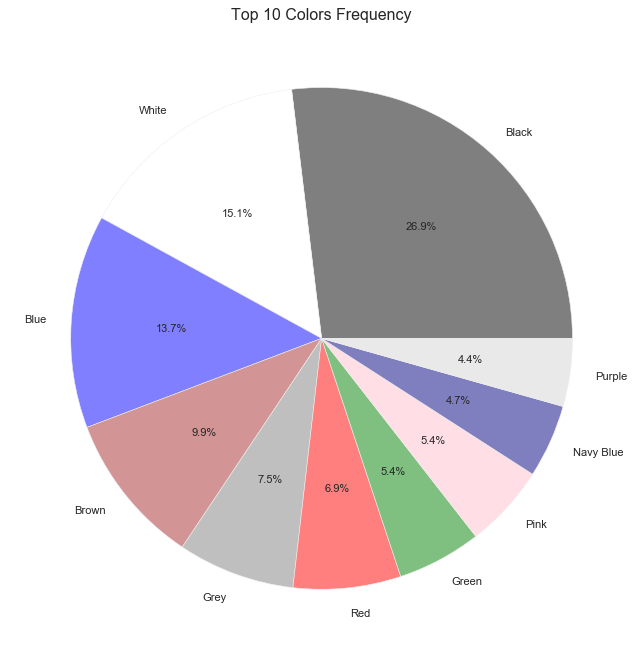

In [220]:
#Count the frequency of each color
color_counts = df['baseColour'].value_counts()


# Select the top 10 colors
top_colors = color_counts.head(10)

# Map some common colors to their respective hex codes for plotting
color_map = {
    'Black': '#000000',
    'Blue': '#0000FF',
    'Red': '#FF0000',
    'Green': '#008000',
    'White': '#FFFFFF',
    'Brown': '#A52A2A',
    'Grey': '#808080',
    'Pink': '#FFC0CB',
    'Navy Blue': '#000080',
    'Yellow': '#FFFF00'
}

# Map the colors to the top 10 colors in the dataset
colors_for_plot = [color_map.get(color, '#D3D3D3') for color in top_colors.index]

# Adjust the colors to be more pastel
def to_pastel(hex_code):
    """Convert a hex color code to a more pastel version."""
    rgb = [int(hex_code[i:i+2], 16) for i in (1, 3, 5)]
    pastel_rgb = [(x + 255) // 2 for x in rgb]
    return '#{:02x}{:02x}{:02x}'.format(*pastel_rgb)

pastel_colors_for_plot = [to_pastel(color) for color in colors_for_plot]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_colors, labels=top_colors.index, colors=pastel_colors_for_plot, autopct='%1.1f%%')
plt.title('Top 10 Colors Frequency')
plt.show()

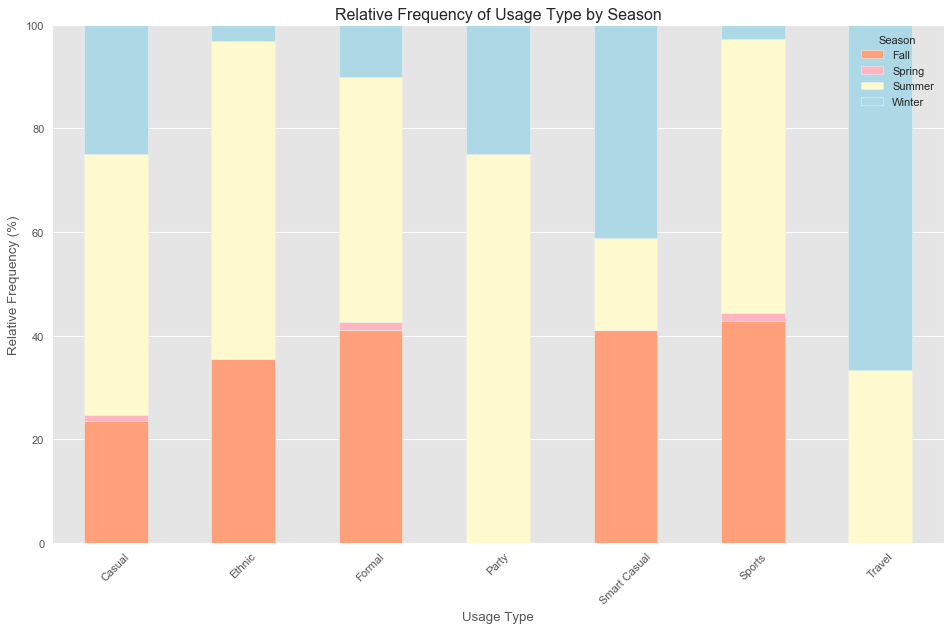

In [234]:
# Define a pastel color palette for the seasons
season_color_palette = {
    'Fall': '#FFA07A',  # Light Salmon (Orange)
    'Spring': '#FFB6C1',  # Light Pink
    'Summer': '#FFFACD',  # Lemon Chiffon (Yellow)
    'Winter': '#ADD8E6'   # Light Blue
}

# Filter out rows with specified masterCategories
filtered_df = df[~df['masterCategory'].isin(['Personal Care', 'Free Items', 'Sporting Goods'])]

# Group the data by usage and season, then count the frequency
usage_season_counts = filtered_df.groupby(['usage', 'season']).size().unstack(fill_value=0)

# Convert the counts to relative frequency (percentage)
usage_season_relative = usage_season_counts.div(usage_season_counts.sum(axis=1), axis=0) * 100

# Plot the data as a stacked bar chart with relative frequency
#ax = usage_season_relative.plot(kind='bar', stacked=True, color=season_color_palette)

usage_season_relative.plot(kind='bar', stacked=True, figsize=(12, 8), color = season_color_palette)
plt.title('Relative Frequency of Usage Type by Season')
plt.xlabel('Usage Type')
plt.ylabel('Relative Frequency (%)')
plt.xticks(rotation=45)
plt.legend(title='Season')
plt.ylim(0, 100)  # Set y-axis limit to 100% for consistency
#ax.set_facecolor('white')
plt.tight_layout()
plt.show()

In [254]:
color_counts = df.groupby('season')['baseColour'].nunique()
print(color_counts)

season
Fall      39
Spring    34
Summer    44
Winter    37
Name: baseColour, dtype: int64


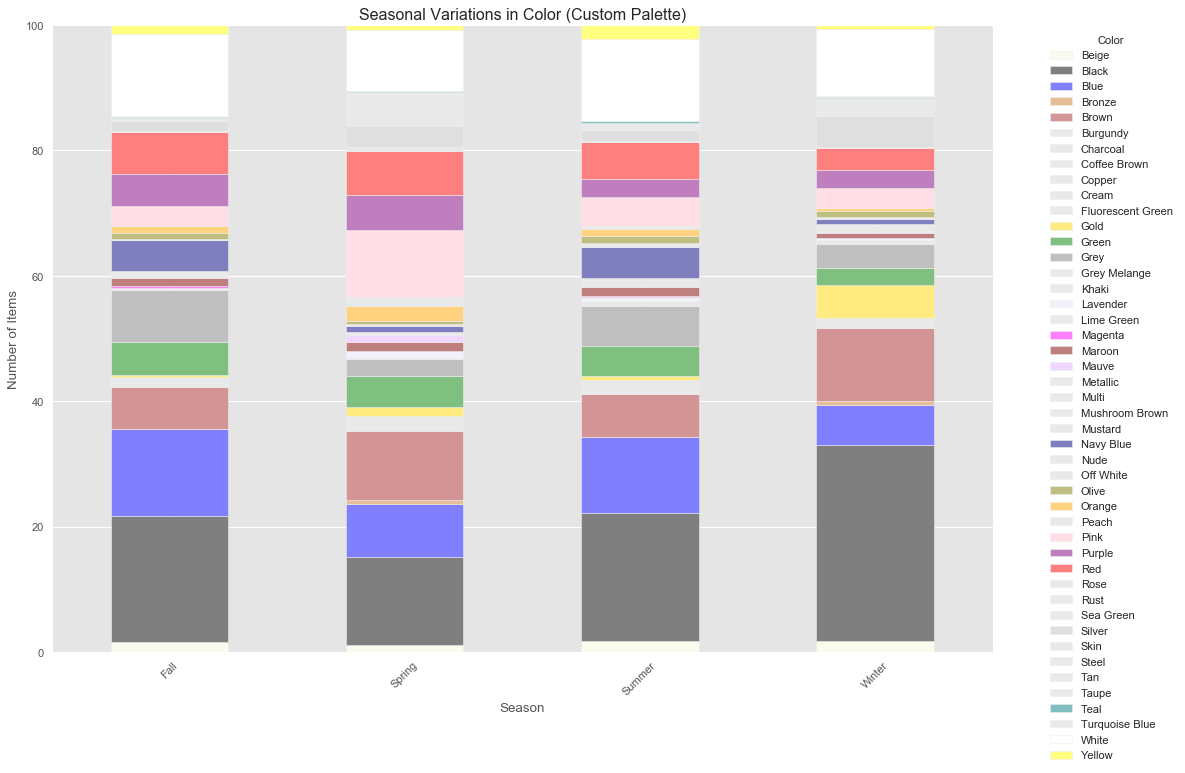

In [242]:
custom_color_palette = {
    'Black': '#000000',
    'Blue': '#0000FF',
    'Red': '#FF0000',
    'Green': '#008000',
    'White': '#FFFFFF',
    'Brown': '#A52A2A',
    'Grey': '#808080',
    'Pink': '#FFC0CB',
    'Navy Blue': '#000080',
    'Yellow': '#FFFF00',
    'Orange': '#FFA500',
    'Purple': '#800080',
    'Beige': '#F5F5DC',
    'Maroon': '#800000',
    'Teal': '#008080',
    'Olive': '#808000',
    'Gold': '#FFD700',
    'Silver': '#C0C0C0',
    'Bronze': '#CD7F32',
    'Magenta': '#FF00FF',
    'Lavender': '#E6E6FA',
    'Mauve': '#E0B0FF'
}

season_color_counts = df.groupby(['season', 'baseColour']).size().unstack(fill_value=0)

season_color_relative = season_color_counts.div(season_color_counts.sum(axis=1), axis=0) * 100

colors_for_plot = [custom_color_palette.get(color, '#D3D3D3') for color in season_color_counts.columns]

pastel_colors_for_plot = [to_pastel(color) for color in colors_for_plot]

season_color_relative.plot(kind='bar', stacked=True, figsize=(12, 8), color=pastel_colors_for_plot)
plt.title('Seasonal Variations in Color (Custom Palette)')
plt.xlabel('Season')
plt.ylabel('Number of Items')
plt.xticks(rotation=45)
plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

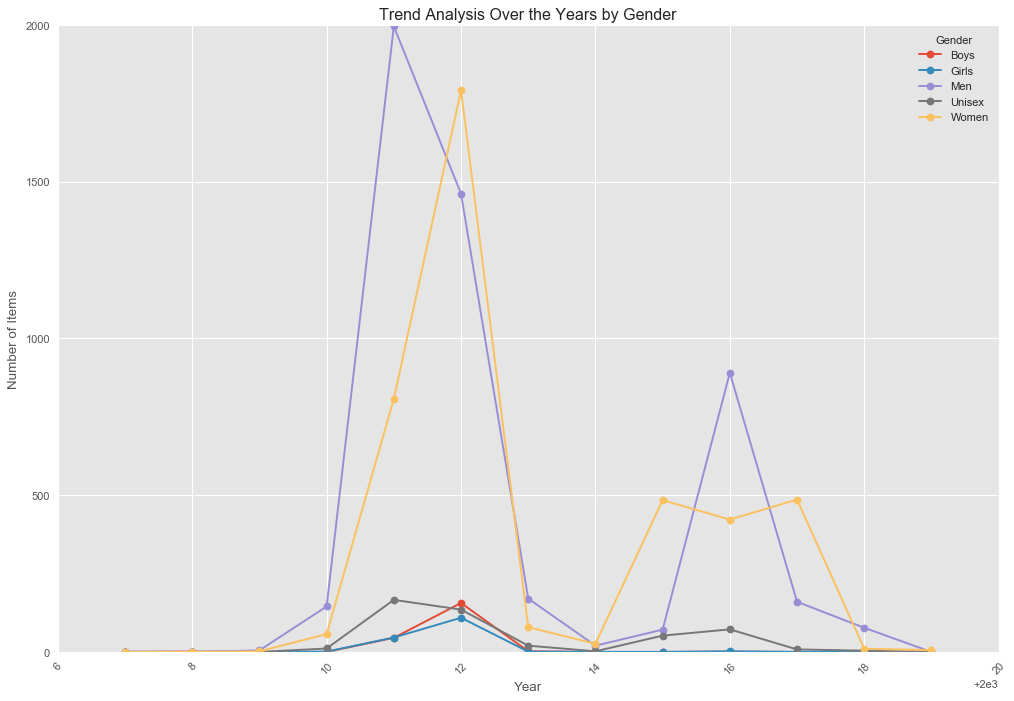

In [237]:
# Group the data by year and gender, then count the frequency of items
year_gender_counts = styles_df.groupby(['year', 'gender']).size().unstack(fill_value=0)

# Plot the trend analysis over the years, divided by gender
year_gender_counts.plot(kind='line', marker='o', figsize=(12, 8))
plt.title('Clothing Analysis Over the Years by Gender')
plt.xlabel('Year')
plt.ylabel('Number of Items')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Gender')
plt.show()

In [262]:
styles_df['brandName'] = styles_df['productDisplayName'].str.split().str[0]

In [269]:
brand_counts = styles_df['brandName'].value_counts()

brandName
Nike        520
ADIDAS      484
Puma        460
United      317
Lino        176
           ... 
Linkin        1
Levi'si       1
ANT           1
Timen         1
GIORDANO      1
Name: count, Length: 400, dtype: int64

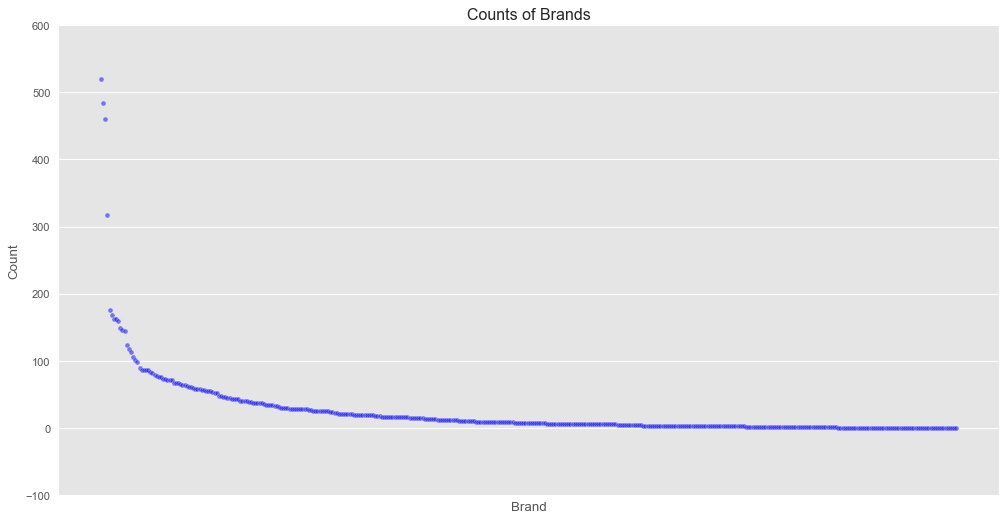

In [276]:
# Count the number of occurrences of each brand
brand_counts = styles_df['brandName'].value_counts()

# Create a scatter plot showing brand and counts of brands
plt.figure(figsize=(12, 6))
plt.scatter(brand_counts.index, brand_counts.values, alpha=0.5)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Counts of Brands')
plt.xticks([])  # Remove x-axis labels
plt.show()

# 2. Building out our Image Classification Prototype

In [32]:
styles_df = styles_df.sample(10000)

In [33]:
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.)

generator = datagen.flow_from_dataframe(dataframe = styles_df,
                                       directory = img_path,
                                       target_size = (img_size,img_size),
                                       x_col = 'filename',
                                       class_mode = None,
                                       batch_size = 32,
                                       shuffle = False,
                                       classes= None)

Found 10000 validated image filenames.


In [34]:
base_model = VGG16(include_top=False, input_shape= (img_size,img_size,3))

for layer in base_model.layers:
    layer.trainable = False
    
    
input_layer = Input(shape=(img_size,img_size,3))
x= base_model(input_layer)
output= GlobalAveragePooling2D()(x)

embeddings = Model(inputs = input_layer, outputs= output)
embeddings.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [35]:
X = embeddings.predict(generator, verbose=1)

/Users/nataliehammel/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step


In [36]:
def read_img(image_path):
    image = load_img(os.path.join(img_path,image_path),target_size=(img_size,img_size,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [37]:
y = styles_df['id']

In [38]:
nearest_neighbors = KNeighborsClassifier(n_neighbors = 7)
nearest_neighbors.fit(X,y)

KNeighborsClassifier(n_neighbors=7)

In [39]:
styles_df = styles_df.reset_index(drop=True)

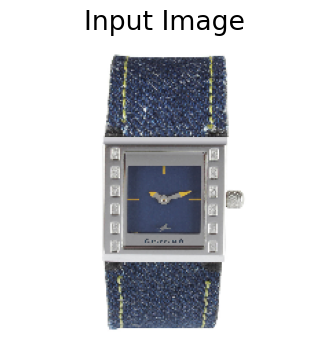

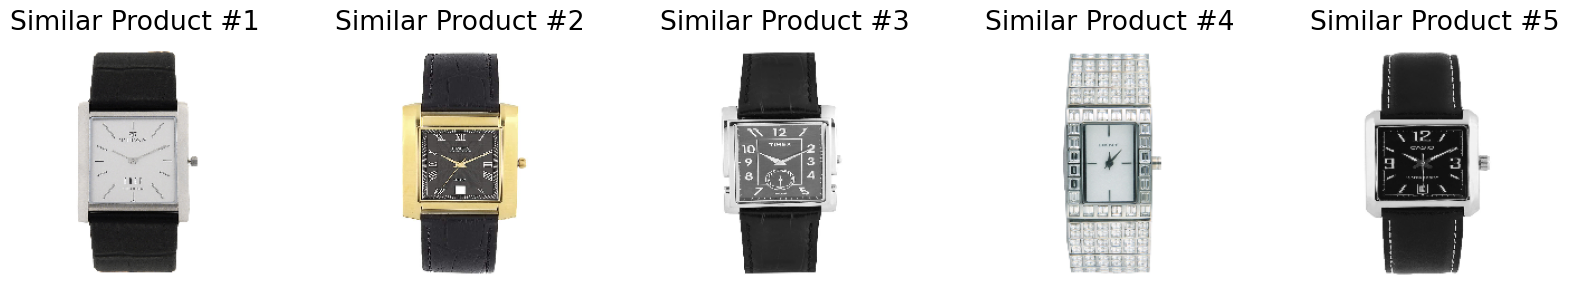

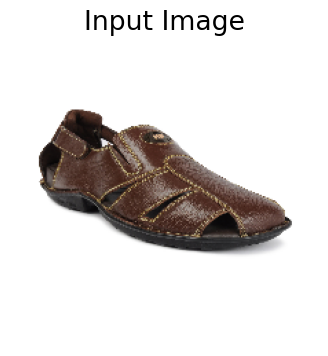

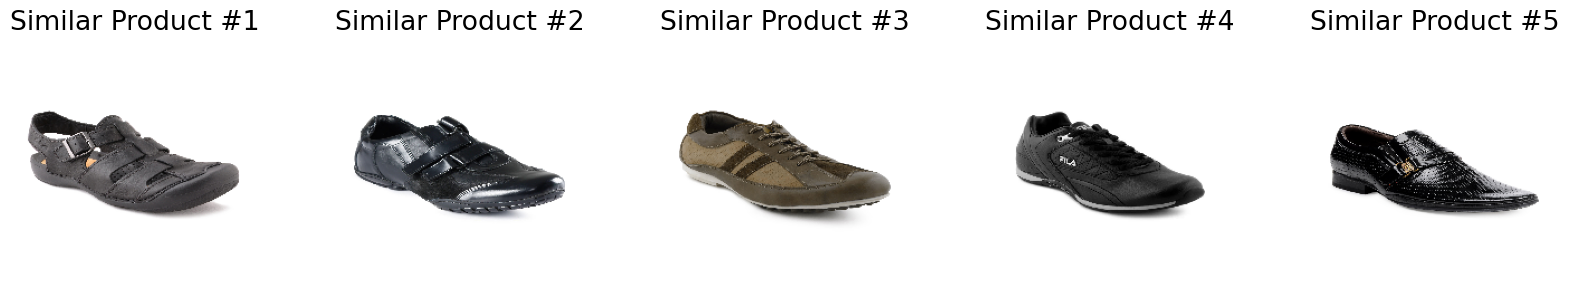

In [40]:
for _ in range(2):
    i = random.randint(0,len(styles_df))
    img1 = read_img(styles_df.loc[i,'filename'])
    dist, index = nearest_neighbors.kneighbors(X=X[i,:].reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.axis('off')
   
    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(styles_df.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')
        plt.axis('off')

# Going Another Route ...

In [121]:
df = styles_df

In [125]:
%%time
import os

def get_all_filenames(directory):
    """
    Returns a set of all filenames in the given directory.
    """
    filenames = {entry.name for entry in os.scandir(directory) if entry.is_file()}
    return filenames

images = get_all_filenames(img_path)

CPU times: user 11.3 ms, sys: 31.4 ms, total: 42.8 ms
Wall time: 134 ms


In [126]:
def check_image_exists(image_filename):
    """
    Checks if the desired filename exists within the filenames found in the given directory.
    Returns True if the filename exists, False otherwise.
    """
    global images
    if image_filename in images:
        return image_filename
    else:
        return np.nan

df['image'] = df["id"].apply(lambda image: check_image_exists(str(image) + ".jpg"))
df = df.reset_index(drop=True)
df.head()

id gender masterCategory subCategory articleType baseColour  season  \
0  47670  Women    Accessories     Scarves     Scarves      Cream  Summer   
1  31980    Men       Footwear      Sandal     Sandals        Red  Summer   
2  26237    Men        Apparel     Topwear     Tshirts     Orange  Summer   
3   4260    Men        Apparel     Topwear     Tshirts     Yellow  Summer   
4  28023    Men        Apparel   Innerwear      Briefs        Red  Summer   

     year   usage                           productDisplayName   filename  \
0  2012.0  Casual  Femella Women Cream and Black Printed Scarf  47670.jpg   
1  2012.0  Casual            Nike Men Lebron Slide Red Sandals  31980.jpg   
2  2012.0  Casual           Proline Men Orange Printed T-shirt  26237.jpg   
3  2011.0  Casual    Inkfruit Men's Music Fever Yellow T-shirt   4260.jpg   
4  2016.0  Casual  Jockey ELANCE Men Red Pack of 2 Briefs 1004  28023.jpg   

   present      image  
0     True  47670.jpg  
1     True  31980.jpg  
2     True  26237.jpg  
3     True   4260.jpg  
4     True  28023.jpg

In [127]:
df = df.dropna(subset=['image'])

In [130]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/77/df/b56175c3fb5bc058774bdcf35f5a71cf9c3c5b909f98a1c688eb71cd3b1f/opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 28.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [134]:
import cv2

In [131]:
pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
Note: you may need to restart the kernel to use updated packages.


In [ ]:
img_path = '/Users/nataliehammel/Downloads/fashion-dataset/'
img_df = pd.read_csv('/Users/nataliehammel/Downloads/fashion-dataset/images.csv')
styles_df = pd.read_csv('/Users/nataliehammel/Downloads/fashion-dataset/styles.csv', on_bad_lines='skip')

In [138]:
DISPLAY_DATASET_PATH = '/Users/nataliehammel/Downloads/fashion-dataset/'
DATASET_PATH = '/Users/nataliehammel/Downloads/fashion-dataset/'
print(os.listdir(DATASET_PATH))

['.DS_Store', 'images.csv', 'images', 'fashion-dataset', 'styles', 'styles.csv']


In [140]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img,display=False):
    if display :
        return DISPLAY_DATASET_PATH+"/images/"+img
    else :
        return DATASET_PATH+"/images/"+img

def load_image(img,display=False):
    return cv2.imread(img_path(img,display))

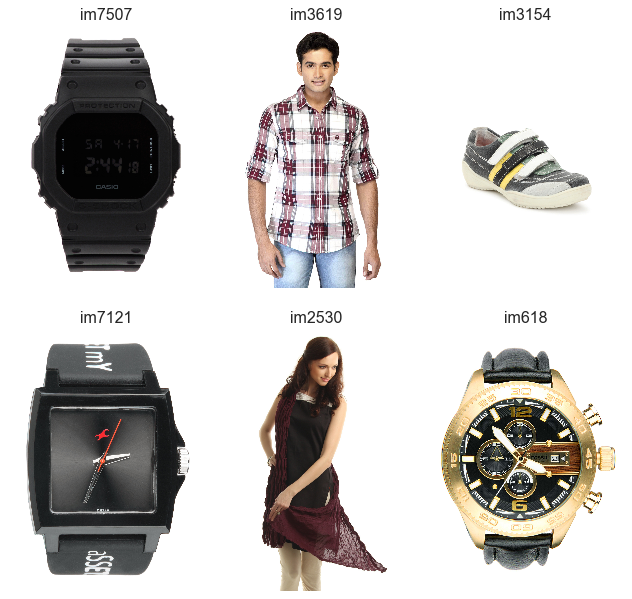

In [141]:
# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image,True) for i, row in df.sample(6).iterrows()}
plot_figures(figures, 2, 3)

In [142]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
tf.__version__

'2.16.1'

In [143]:
# Input Shape
img_width, img_height, _ = load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [144]:
i = 0
import time
start_time = time.time()
def get_embedding(model, img_name):
    global i, start_time
    if((i < 1000 and i%50 == 0) or i%200 == 0):
        print(i, "Time elapsed so far: {:.2f} minutes".format((time.time() - start_time) / 60))
    i += 1
    
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x,verbose=0).reshape(-1)

In [145]:
emb = get_embedding(model, df.iloc[59].image)
emb.shape

0 Time elapsed so far: 0.14 minutes


(2048,)

[ 3.597403  12.35433    3.6221814 ...  0.9604515  7.4209948  5.9118385]


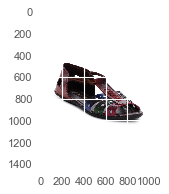

In [146]:
plt.imshow(cv2.cvtColor(load_image(df.iloc[59].image,True), cv2.COLOR_BGR2RGB))
print(emb)

In [148]:
import dask.dataframe as dd

# Create a Dask dataframe from your Pandas dataframe
# dask_df = dd.from_pandas(df, npartitions=8)
dask_df = dd.from_pandas(df, npartitions=32)

# Define the expected output type of your function
meta = pd.Series([], dtype=float)

In [149]:
%%time
import time
start_time = time.time()
i = 0

# Apply the function to each partition of the dataframe in parallel
dask_result = dask_df['image'].map(lambda img: get_embedding(model, img), meta=meta)

# Compute the result
result = dask_result.compute().reset_index(drop=True)

00 Time elapsed so far: 0.01 minutes
 Time elapsed so far: 0.01 minutes
50 Time elapsed so far: 0.35 minutes
100 Time elapsed so far: 0.68 minutes
150 Time elapsed so far: 1.02 minutes
200 Time elapsed so far: 1.35 minutes
250 Time elapsed so far: 1.68 minutes
300 Time elapsed so far: 2.04 minutes
350 Time elapsed so far: 2.36 minutes
400 Time elapsed so far: 2.70 minutes
450 Time elapsed so far: 3.02 minutes
500 Time elapsed so far: 3.34 minutes
550 Time elapsed so far: 3.68 minutes
600 Time elapsed so far: 4.01 minutes
650 Time elapsed so far: 4.35 minutes
700 Time elapsed so far: 4.69 minutes
750 Time elapsed so far: 5.02 minutes
800 Time elapsed so far: 5.35 minutes
850 Time elapsed so far: 5.70 minutes
900 Time elapsed so far: 6.02 minutes
950 Time elapsed so far: 6.34 minutes
1000 Time elapsed so far: 6.67 minutes
1200 Time elapsed so far: 8.02 minutes
1400 Time elapsed so far: 9.33 minutes
1600 Time elapsed so far: 10.67 minutes
1800 Time elapsed so far: 11.97 minutes
2000 Time 

In [150]:
print(result.shape)
result.head()

(10000,)


0    [5.7500563, 13.739292, 2.7085183, 12.240858, 1...
1    [9.601214, 9.602699, 6.7161884, 1.1981566, 15....
2    [6.177665, 13.950401, 4.6123967, 9.542025, 6.3...
3    [8.029124, 24.98336, 5.1041245, 10.581123, 6.1...
4    [6.443349, 9.215286, 4.1296344, 1.0273262, 13....
Name: image, dtype: object

In [151]:
df_embds = result.apply(pd.Series)

In [152]:
print(df_embds.shape)
df_embds.head()

(10000, 2048)


0          1         2          3          4          5          6     \
0  5.750056  13.739292  2.708518  12.240858  11.948583   3.595436   6.540311   
1  9.601214   9.602699  6.716188   1.198157  15.866727  13.395620   7.977005   
2  6.177665  13.950401  4.612397   9.542025   6.366776   2.618166  21.829206   
3  8.029124  24.983360  5.104125  10.581123   6.131118   7.245897   9.644329   
4  6.443349   9.215286  4.129634   1.027326  13.833910   6.927792  13.968382   

        7         8         9     ...       2038      2039       2040  \
0  25.566914  0.978796  6.812798  ...   6.184510  7.636975   5.764258   
1  13.475350  5.109799  7.178946  ...  17.058453  9.976728  11.661242   
2  14.229182  1.323500  7.825933  ...  16.059795  6.365150   5.919652   
3  18.902992  2.832401  4.319396  ...  10.563055  4.270139   6.805367   
4  18.354427  4.705793  1.857304  ...  14.129422  4.580465  10.099175   

        2041       2042       2043       2044       2045      2046       2047  
0   9.303238  19.061453   6.323742   3.444635   3.687328  8.043252  17.785633  
1   7.626490  13.278742  10.835464   5.534636   6.665129  5.153433   8.244843  
2  12.149503   9.369860   3.641434   4.442477  10.730808  7.384189  10.324128  
3  16.178190  25.005201  10.240627  10.853301  21.172531  4.571732  15.002680  
4   5.289950   9.969932   2.834732   7.269872   4.156699  5.959404   7.774470  

[5 rows x 2048 columns]

In [153]:
from scipy import sparse

# df_embds.to_csv("df_embds_img.csv",index=False)
# Convert DataFrame to a sparse matrix
sparse_matrix = sparse.csr_matrix(df_embds.values)

# Save the sparse matrix to a file
sparse.save_npz('sparse_matrix_df_embds_img.npz', sparse_matrix)

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenate the text columns into a single column
df['combined_text'] = [' '.join(row) for row in df[['gender', 'masterCategory', 'subCategory', 'articleType',
                                                     'baseColour', 'season', 'year', 'usage',
                                                     'productDisplayName']].values.astype(str)]


# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the combined_text column
tfidf_embeddings = vectorizer.fit_transform(df['combined_text'])

# tfidf_embeddings is a sparse matrix containing the TF-IDF vectors
tfidf_embeddings

<10000x4182 sparse matrix of type '<class 'numpy.float64'>'
	with 112796 stored elements in Compressed Sparse Row format>

In [155]:
from scipy import sparse

# Save the sparse matrix to a file
sparse.save_npz('sparse_matrix_df_embds_tfidf.npz', tfidf_embeddings)

In [156]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matrix
cosine_sim_imgs = 1-pairwise_distances(df_embds, metric='cosine')
cosine_sim_imgs[:4, :4]

array([[0.9999986 , 0.80363077, 0.83783334, 0.8562185 ],
       [0.80363077, 1.        , 0.7772583 , 0.8042955 ],
       [0.83783334, 0.7772583 , 1.        , 0.8829759 ],
       [0.8562185 , 0.8042955 , 0.8829759 , 1.        ]], dtype=float32)

In [157]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matrix
cosine_sim_tfidf = 1-pairwise_distances(tfidf_embeddings, metric='cosine')
cosine_sim_tfidf[:4, :4]

array([[1.        , 0.02167216, 0.07030018, 0.01171525],
       [0.02167216, 1.        , 0.07527482, 0.04654377],
       [0.07030018, 0.07527482, 1.        , 0.14915898],
       [0.01171525, 0.04654377, 0.14915898, 1.        ]])

In [158]:
cosine_sim = cosine_sim_tfidf * 0.3 + cosine_sim_imgs * 0.7

In [217]:
print(cosine_sim.shape)
sample = cosine_sim[:4,:4]

(10000, 10000)


In [160]:
indices = pd.Series(range(len(df)), index=df.index)
indices.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [161]:
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

In [214]:
index, sim = get_recommender(217, df, top_n = 12)

In [216]:
sim

[0.9258609294891358,
 0.9236595511436463,
 0.9144159820557378,
 0.9004630711556219,
 0.8898164019559112,
 0.8832272912268114,
 0.8739720546633386,
 0.8735848909530279,
 0.8717179356136704,
 0.8710307442576074,
 0.87072289567379,
 0.8706271706142807]

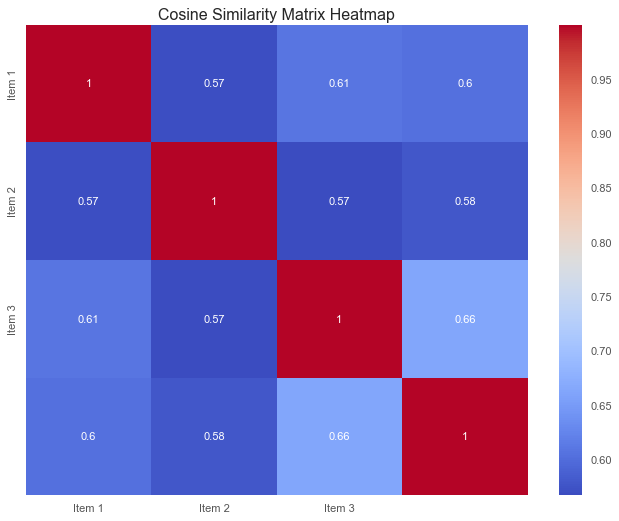

In [218]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample cosine similarity matrix

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sample, annot=True, cmap='coolwarm', xticklabels=['Item 1', 'Item 2', 'Item 3'], yticklabels=['Item 1', 'Item 2', 'Item 3'])
plt.title('Cosine Similarity Matrix Heatmap')
plt.show()

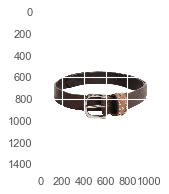

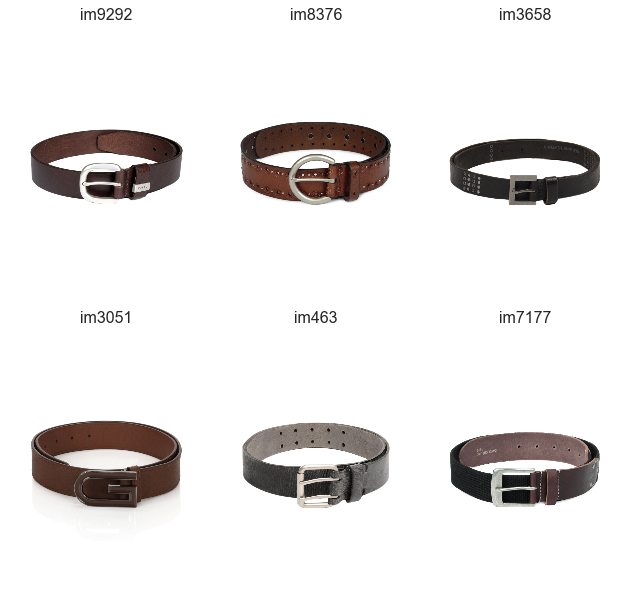

In [163]:
# Idx Item to Recommender
idx_ref = 200

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image,True), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image,True) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

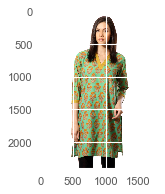

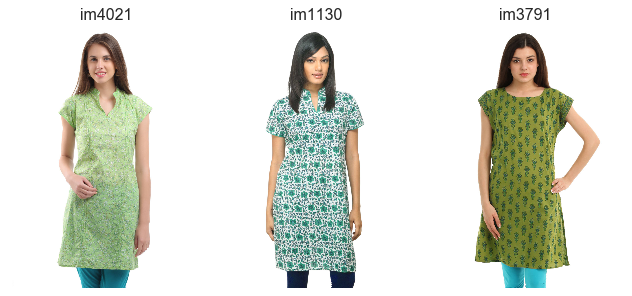

In [203]:
# Idx Item to Recommender
idx_ref = 217

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 3)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image,True), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image,True) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 1, 3)

In [164]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [165]:
%%time
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embds)

CPU times: user 1min 17s, sys: 25 s, total: 1min 42s
Wall time: 9.22 s


In [166]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

In [168]:
pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=d516cb92bc8a2131ad11f5c118c8a05f6e1e96d06a3f8ef20039b65a1ea1487c
  Stored in directory: /Users/nataliehammel/Library/Caches/pip/wheels/82/d8/73/e9eb3334baaad795ff0278363ff1aca7568bdf2793e452a527
Successfully built umap
Note: you may need to restart the kernel to use updated packages.


In [171]:
import umap

In [205]:
pip install umap-learn[plot]

zsh:1: no matches found: umap-learn[plot]
Note: you may need to restart the kernel to use updated packages.


In [204]:
pip install umap-learn

  Obtaining dependency information for umap-learn from https://files.pythonhosted.org/packages/d1/1b/46802a050b1c55d10c4f59fc6afd2b45ac9b4f62b2e12092d3f599286f14/umap_learn-0.5.6-py3-none-any.whl.metadata
  Obtaining dependency information for pynndescent>=0.5 from https://files.pythonhosted.org/packages/bf/06/18c0e17eb245b7caeb861f2ff747adb0575500183b6ec4282d5350d29e9f/pynndescent-0.5.12-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [178]:
pip install -U ipykernel

  Obtaining dependency information for ipykernel from https://files.pythonhosted.org/packages/53/9d/40d5207db523363d9b5698f33778c18b0d591e3fdb6e0116b894b2a2491c/ipykernel-6.29.4-py3-none-any.whl.metadata
  Obtaining dependency information for pyzmq>=24 from https://files.pythonhosted.org/packages/35/de/7579518bc58cebf92568b48e354a702fb52525d0fab166dc544f2a0615dc/pyzmq-25.1.2-cp311-cp311-macosx_10_15_universal2.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.3 MB/s eta 0:00:00:00:010:01m
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 23.2.0
    Uninstalling pyzmq-23.2.0:
      Successfully uninstalled pyzmq-23.2.0
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 6.25.0
    Uninstalling ipykernel-6.25.0:
      Successfully uninstalled ipykernel-6.25.0
ERROR: pip's dependency resolver does not currently take into account all the p

In [210]:
fr

ERROR: Could not find a version that satisfies the requirement umap.UMAP (from versions: none)
ERROR: No matching distribution found for umap.UMAP
Note: you may need to restart the kernel to use updated packages.


In [208]:
import umap.plot
mapper_org = umap.UMAP().fit(tsne_results)
umap.plot.points(mapper_org, labels=df["masterCategory"], theme='fire')

/Users/nataliehammel/anaconda3/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


AttributeError: module 'umap' has no attribute 'UMAP'

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

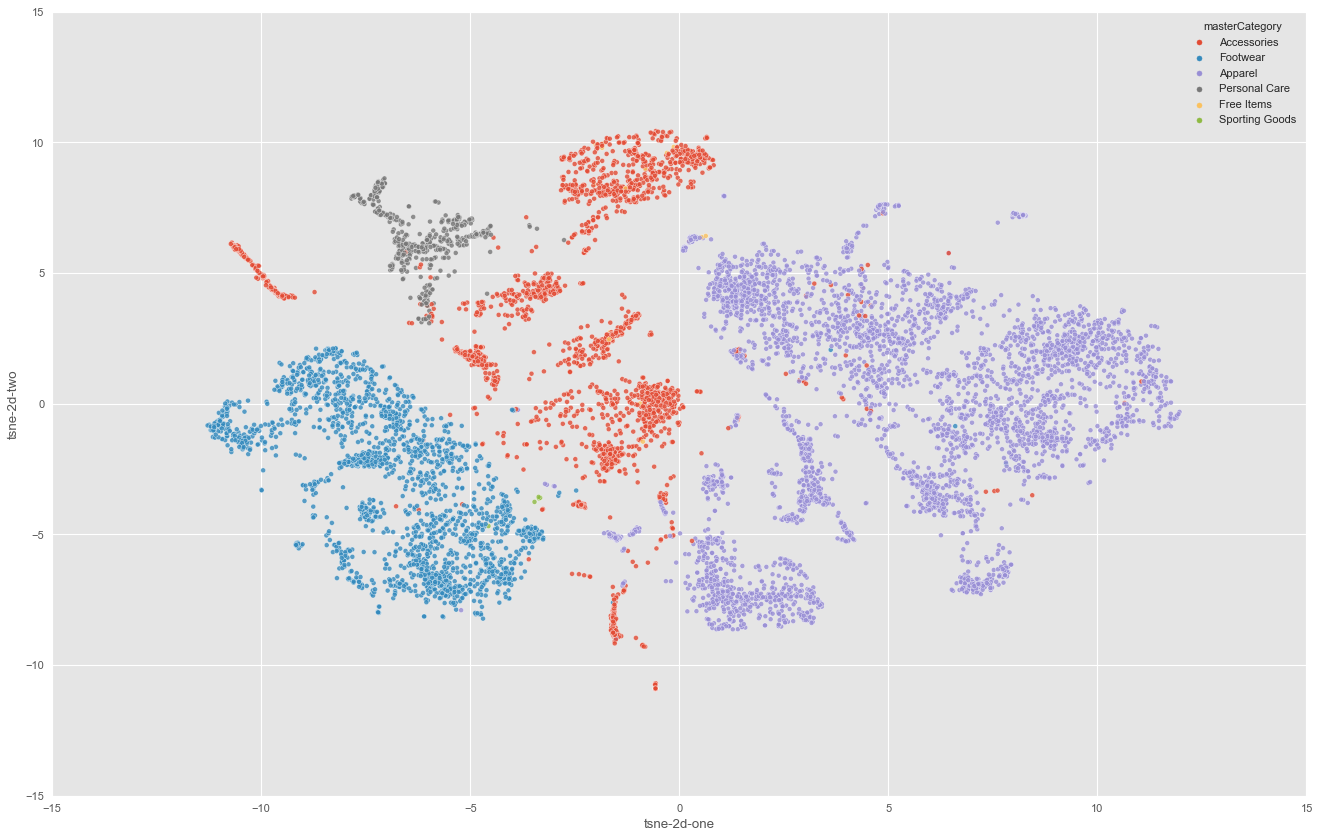

In [206]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

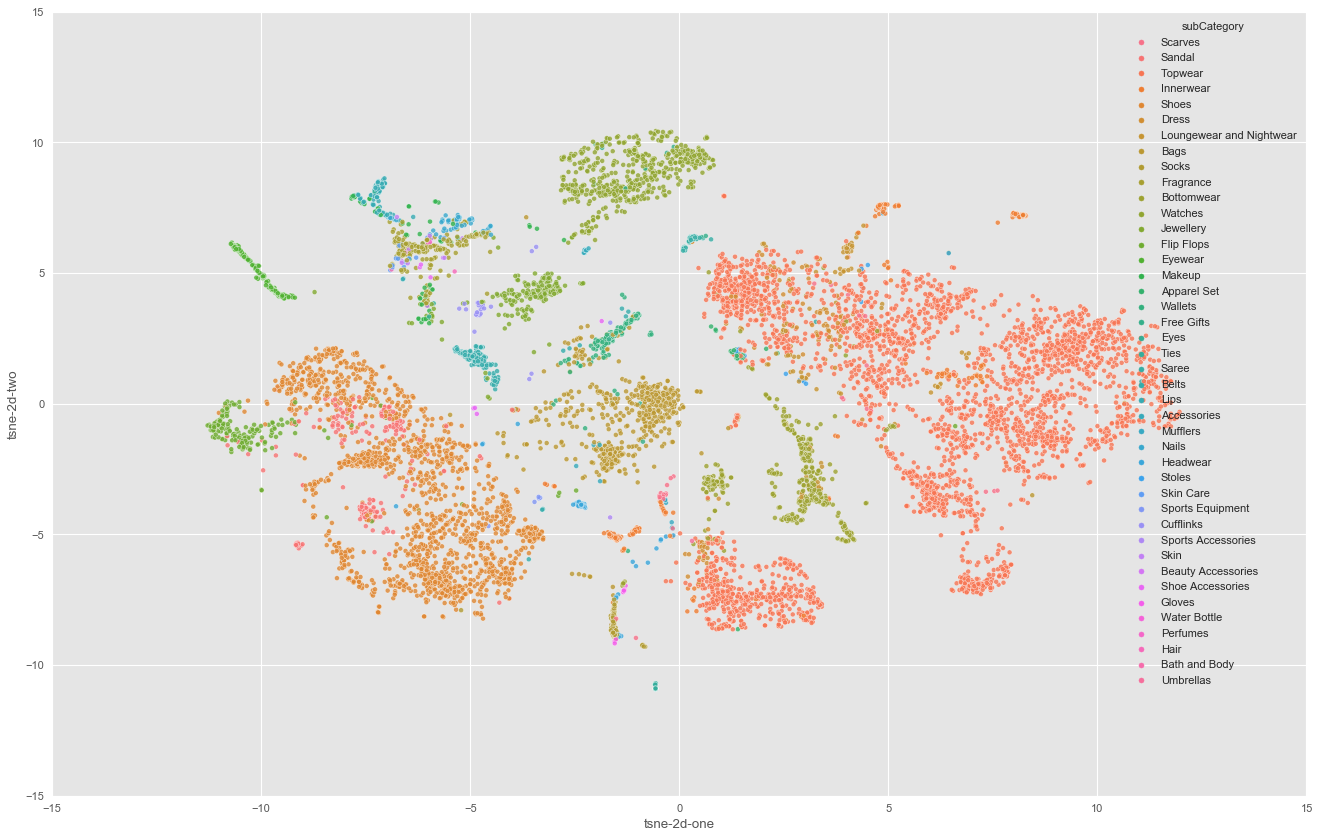

In [207]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [255]:
from sklearn.decomposition import PCA

In [257]:
pca = PCA(2)
pca_df = pca.fit_transform(df_embds)

In [259]:
styles_df[['pc1', 'pc2']] = pca_df

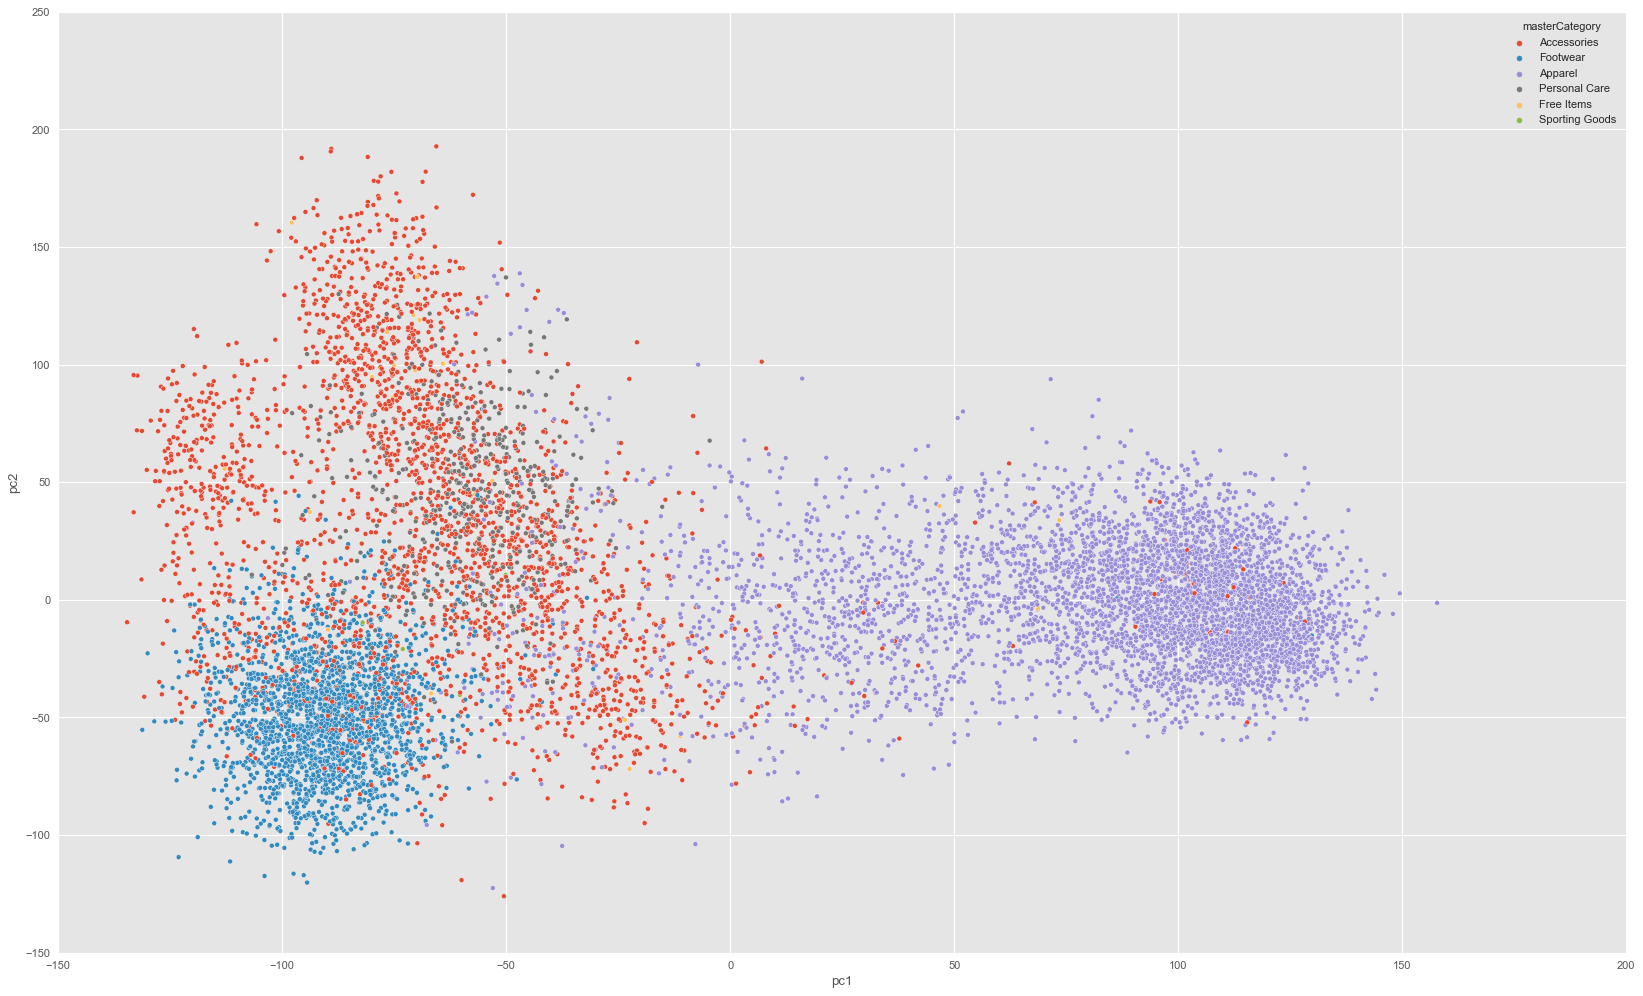

In [260]:
plt.figure(figsize = (20, 12))
sns.scatterplot(x = 'pc1', y = 'pc2', data = styles_df, hue = 'masterCategory')
plt.show()